# Proyek Klasifikasi Gambar: [[Garbage Classification](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)]
- **Nama:** Ch Angga Marcelio
- **Email:** chmarcel0603@gmail.com
- **ID Dicoding:** MC315D5Y1131

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/garbage"

### Data Preprocessing

In [5]:
classes = os.listdir(data_dir)
print("Kelas sampah yang tersedia:", classes)

Kelas sampah yang tersedia: ['paper', 'brown-glass', 'cardboard', 'metal', 'plastic', 'white-glass', 'trash', 'shoes', 'clothes', 'green-glass', 'battery', 'biological']


In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


In [7]:
def count_images_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([file for file in os.listdir(class_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

counts = count_images_per_class(data_dir)
for class_name, count in counts.items():
    print(class_name, ":", count)

paper : 1050
brown-glass : 607
cardboard : 891
metal : 769
plastic : 865
white-glass : 775
trash : 697
shoes : 1977
clothes : 5325
green-glass : 629
battery : 945
biological : 985


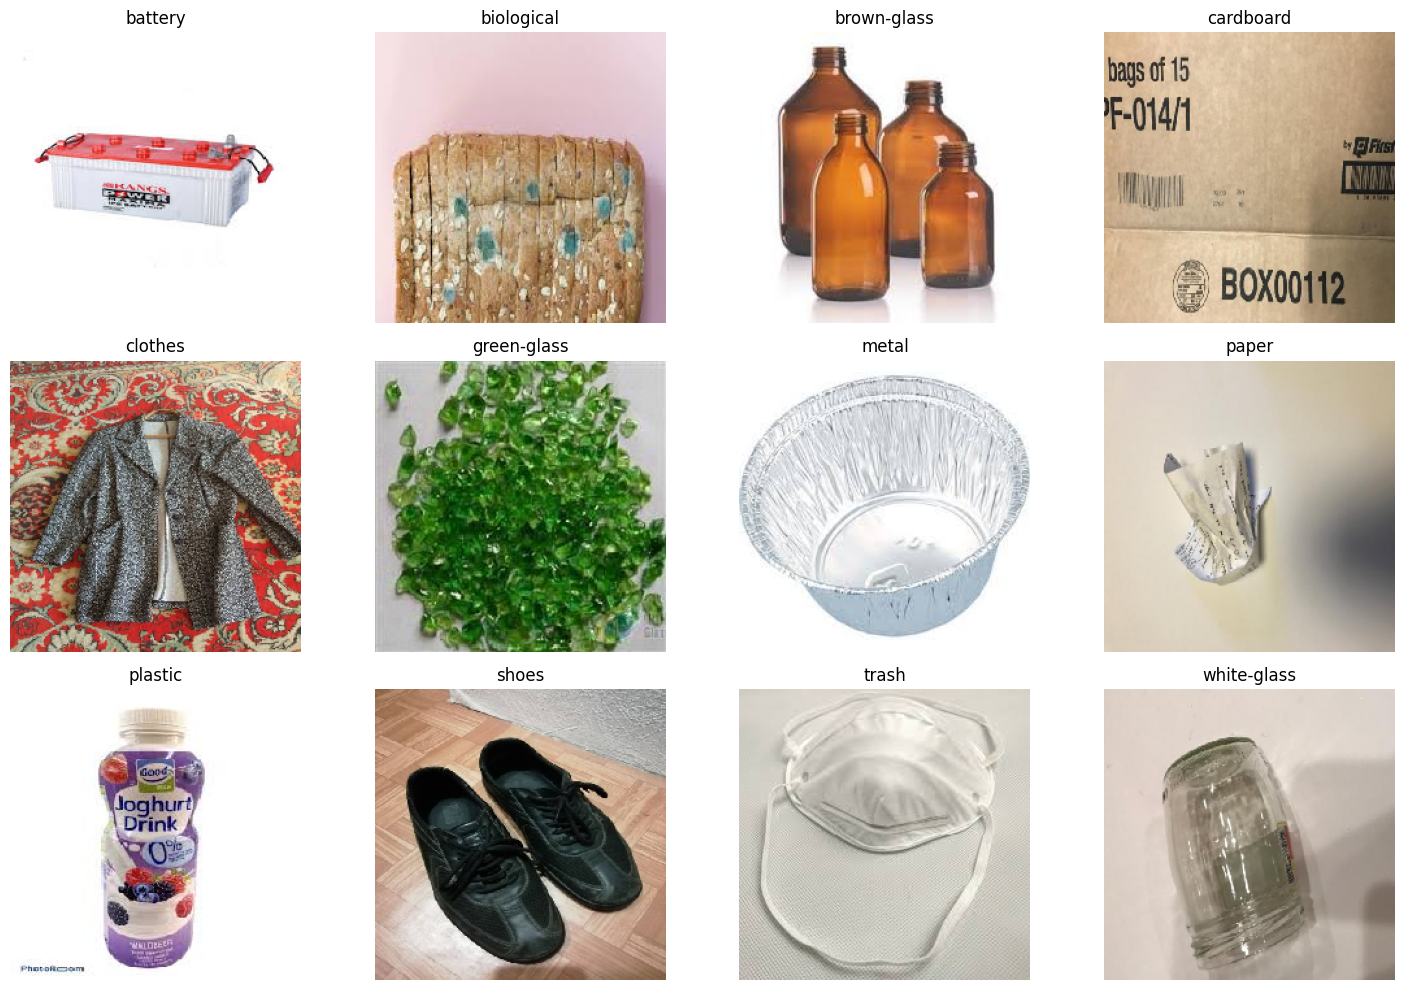

In [8]:
# Dapatkan daftar kelas
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)

# Setup plot
plt.figure(figsize=(15, 10))

# Loop melalui setiap kelas
for i, class_name in enumerate(classes):
    # Dapatkan path ke gambar pertama di setiap kelas
    class_path = os.path.join(data_dir, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not img_files:
        print(f"Tidak ada gambar ditemukan di kelas {class_name}")
        continue

    img_path = os.path.join(class_path, img_files[0])  # Ambil gambar pertama

    try:
        # Load gambar dengan preprocessing yang sama seperti model
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalisasi

        plt.subplot(3, 4, i+1)
        plt.imshow(img_array)
        plt.title(class_name)
        plt.axis('off')
    except Exception as e:
        print(f"Gagal memuat gambar {img_path}: {str(e)}")

plt.tight_layout()
plt.show()

In [9]:
# Daftar kelas yang ingin dipilih
selected_classes = ['paper', 'glass', 'cardboard', 'metal', 'plastic', 'white-glass', 'trash', 'shoes', 'clothes']

# List untuk menyimpan path dan label
img_paths = []
labels = []

# Karena kamu hanya punya satu direktori (bukan list), maka kita hanya iterasi dari situ
for class_name in os.listdir(data_dir):
    if class_name in selected_classes:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_name)
                img_paths.append(img_path)
                label = 'glass' if class_name == 'white-glass' else class_name
                labels.append(label)

# Buat dataframe
df = pd.DataFrame({
    'imgPath': img_paths,
    'label': labels
})

# Acak data
df = df.sample(frac=1).reset_index(drop=True)

# Tampilkan hasilnya
df.head()


,imgPath,label
0,/content/drive/MyDrive/Colab Notebooks/garbage...,cardboard
1,/content/drive/MyDrive/Colab Notebooks/garbage...,shoes
2,/content/drive/MyDrive/Colab Notebooks/garbage...,glass
3,/content/drive/MyDrive/Colab Notebooks/garbage...,shoes
4,/content/drive/MyDrive/Colab Notebooks/garbage...,shoes


In [10]:
# Fungsi untuk membagi DataFrame dengan rasio tertentu untuk setiap kelas
def DataFrameSpliting(df, ratio, classesList):
    trainDf = pd.DataFrame(columns=['imgPath', 'label'])
    testDf = pd.DataFrame(columns=['imgPath', 'label'])

    for clas in classesList:
        tempDf = df[df['label'] == clas].sample(frac=1).reset_index(drop=True)
        split_index = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:split_index]     # 85% training
        testClassDf = tempDf[split_index:]      # 15% testing

        trainDf = pd.concat([trainDf, trainClassDf], axis=0)
        testDf = pd.concat([testDf, testClassDf], axis=0)

    # Final shuffle and reset index
    return trainDf.sample(frac=1).reset_index(drop=True), testDf.sample(frac=1).reset_index(drop=True)

# Daftar kelas dari label yang ada
classList = df['label'].unique().tolist()

# Lakukan splitting
trainDf, testDf = DataFrameSpliting(df, 0.85, classList)

# Cek hasil
print("Jumlah data train:", len(trainDf))
print("Jumlah data test:", len(testDf))
trainDf.head()


Jumlah data train: 10493
Jumlah data test: 1856


,imgPath,label
0,/content/drive/MyDrive/Colab Notebooks/garbage...,cardboard
1,/content/drive/MyDrive/Colab Notebooks/garbage...,metal
2,/content/drive/MyDrive/Colab Notebooks/garbage...,paper
3,/content/drive/MyDrive/Colab Notebooks/garbage...,plastic
4,/content/drive/MyDrive/Colab Notebooks/garbage...,clothes


In [11]:
trainDf

,imgPath,label
0,/content/drive/MyDrive/Colab Notebooks/garbage...,cardboard
1,/content/drive/MyDrive/Colab Notebooks/garbage...,metal
2,/content/drive/MyDrive/Colab Notebooks/garbage...,paper
3,/content/drive/MyDrive/Colab Notebooks/garbage...,plastic
4,/content/drive/MyDrive/Colab Notebooks/garbage...,clothes
...,...,...
10488,/content/drive/MyDrive/Colab Notebooks/garbage...,glass
10489,/content/drive/MyDrive/Colab Notebooks/garbage...,clothes
10490,/content/drive/MyDrive/Colab Notebooks/garbage...,shoes
10491,/content/drive/MyDrive/Colab Notebooks/garbage...,clothes


In [12]:
trainDf['label'].value_counts()

,count
label,
clothes,4526
shoes,1680
paper,892
cardboard,757
plastic,735
glass,658
metal,653
trash,592


#### Split Dataset

In [13]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 10493 validated image filenames belonging to 8 classes.
Found 1856 validated image filenames belonging to 8 classes.
Training set size: 10493
Testing set size: 1856


## Modelling

In [14]:
with tf.device('/GPU:0'):  # To use GPU
    model = Sequential([
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.08),
        Dense(8, activation='softmax')
    ])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
preTrainedModel = model.layers[0]
for layer in preTrainedModel.layers[:-4]:
    layer.trainable = False

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [17]:
class StopAt95Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') is not None:
            val_acc = logs['val_accuracy']
            if val_acc >= 0.95:
                print(f"\nVal accuracy {val_acc:.4f} reached 95%, stopping training.")
                self.model.stop_training = True

In [18]:
history = model.fit(
    trainGenerator,
    validation_data=testGenerator,
    epochs=30,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=4,
            monitor='val_accuracy',
            restore_best_weights=True
        ),
        StopAt95Accuracy()
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 3642s 22s/step - accuracy: 0.8187 - loss: 0.6125 - val_accuracy: 0.9224 - val_loss: 0.2558
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 877s 5s/step - accuracy: 0.9256 - loss: 0.2262 - val_accuracy: 0.9380 - val_loss: 0.1879
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 829s 5s/step - accuracy: 0.9446 - loss: 0.1697 - val_accuracy: 0.9332 - val_loss: 0.2155
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 844s 5s/step - accuracy: 0.9508 - loss: 0.1424 - val_accuracy: 0.9477 - val_loss: 0.1932
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 846s 5s/step - accuracy: 0.9596 - loss: 0.1183 - val_accuracy: 0.9467 - val_loss: 0.1837
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 852s 5s/step - accuracy: 0.9623 - loss: 0.1139 - val_accuracy: 0.9483 - val_loss: 0.1679
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9700 - loss: 0.0847
Val accuracy 0.9520 reached 95%, stopping training.
164/164 ━━━━━━━━━━━━━━━━━━━━ 847s 5s/step - accuracy: 0.9700 - loss: 0.0847 - val_accur

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,128,090 (57.71 MB)

 Trainable params: 4,427,592 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,855,186 (33.78 MB)

## Evaluasi dan Visualisasi

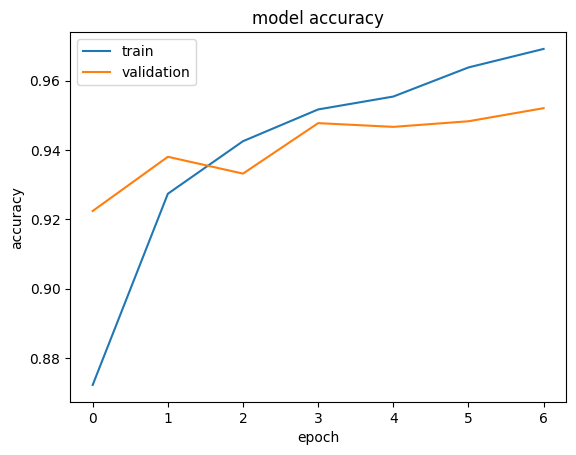

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [21]:
predictions = model.predict(testGenerator)

232/232 ━━━━━━━━━━━━━━━━━━━━ 93s 390ms/step


In [22]:
trainGenerator.class_indices

{'cardboard': 0,
 'clothes': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'shoes': 6,
 'trash': 7}

In [23]:
test_loss, test_accuracy = model.evaluate(testGenerator)
test_accuracy

232/232 ━━━━━━━━━━━━━━━━━━━━ 89s 381ms/step - accuracy: 0.9556 - loss: 0.1289


0.9520474076271057

In [24]:
trueClasses = testGenerator.classes
trueClasses[:10]

[1, 4, 1, 1, 5, 1, 2, 1, 1, 6]

In [25]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([1, 4, 1, 1, 5, 1, 2, 1, 1, 6])

In [26]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report: \n', ClassificationReport )

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       134
           1       0.98      0.99      0.99       799
           2       0.88      0.88      0.88       117
           3       0.96      0.84      0.90       116
           4       0.95      0.91      0.93       158
           5       0.81      0.87      0.84       130
           6       0.97      0.97      0.97       297
           7       0.94      0.96      0.95       105

    accuracy                           0.95      1856
   macro avg       0.93      0.92      0.92      1856
weighted avg       0.95      0.95      0.95      1856



In [27]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)
    true_class_idx = np.argmax(true_labels_batch[0])

    prediction = model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])

    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 20:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


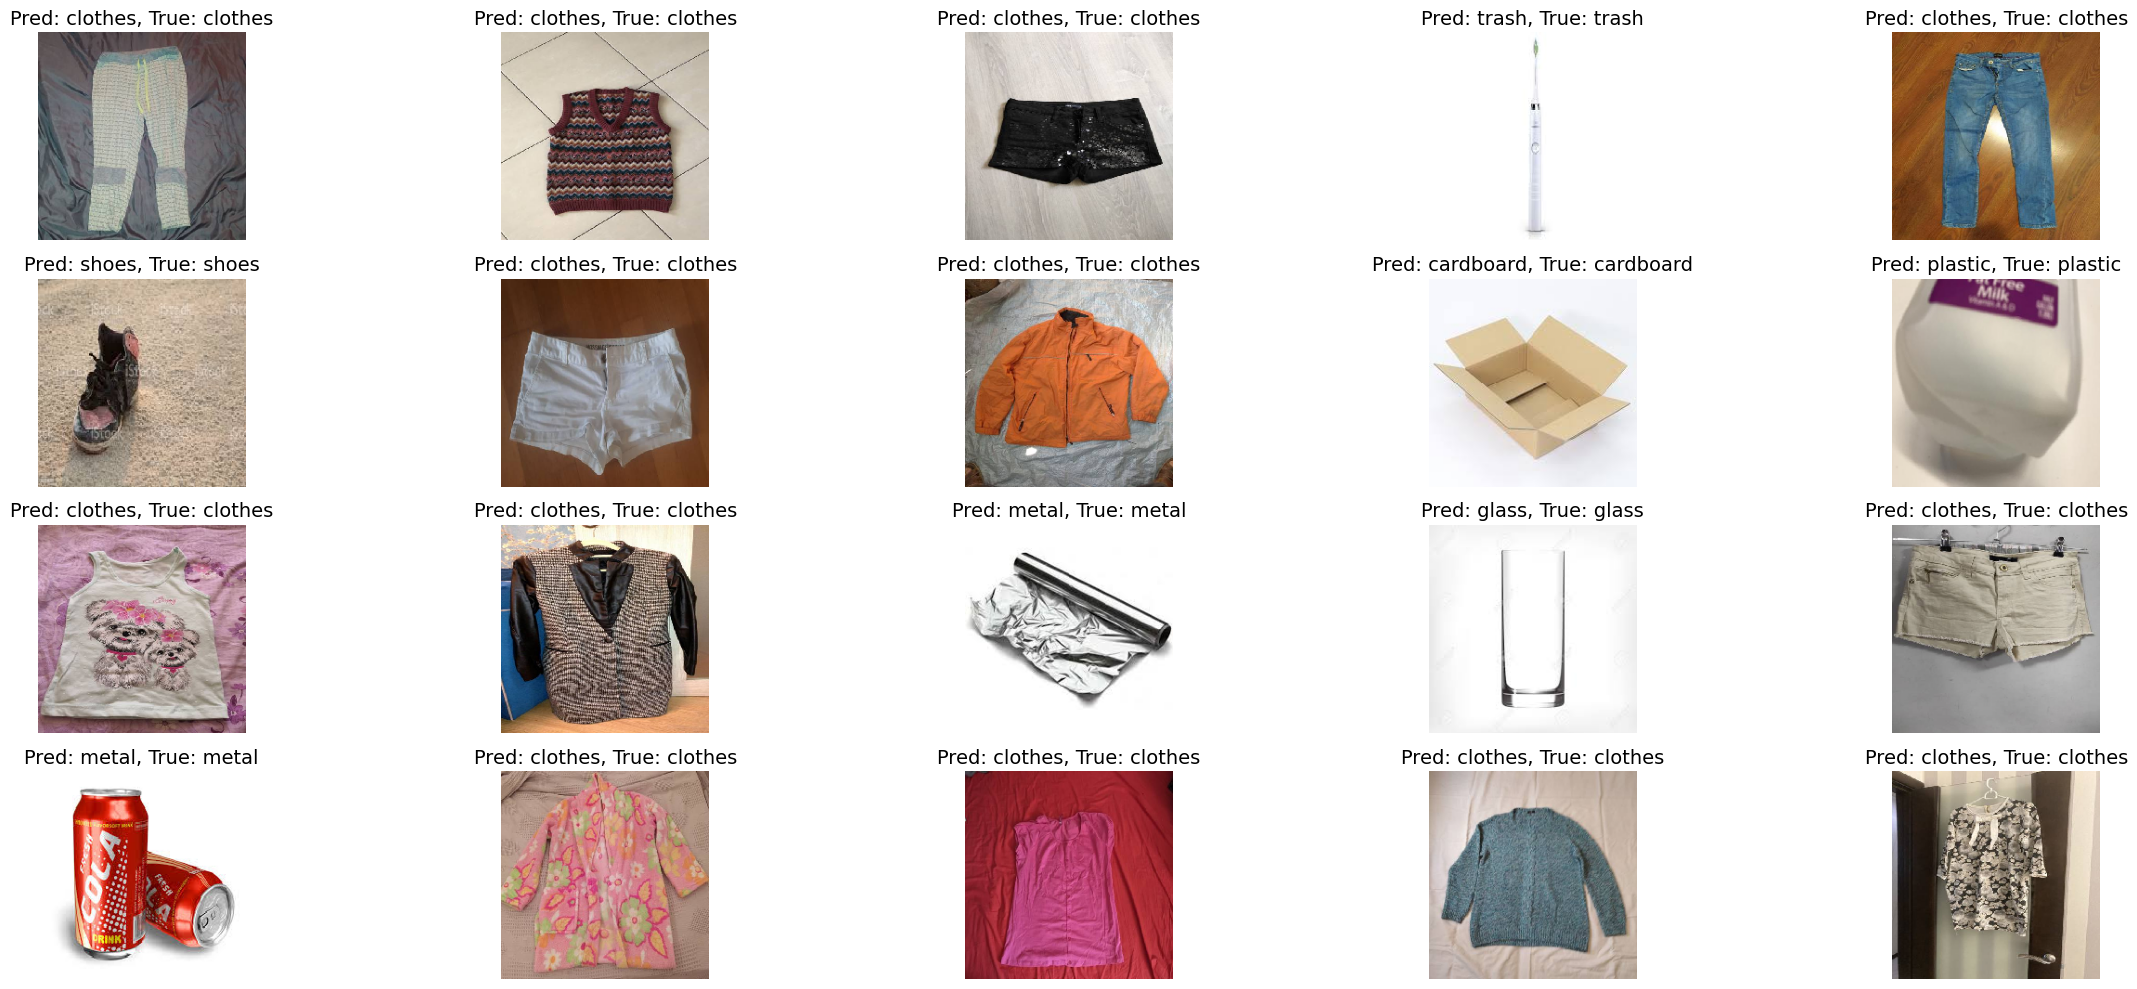

In [28]:
fig, axs = plt.subplots(4, 5, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Konversi Model

In [29]:
#Simpan Model
os.makedirs('submission/tfjs_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)

# Simpan ke SavedModel
model.export('submission/saved_model/garbage_classifier')

converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model/garbage_classifier')
tflite_model = converter.convert()

with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

with open('submission/tflite/label.txt', 'w') as f:
    f.write('\n'.join(train_generator.class_indices.keys()))

import tensorflowjs as tfjs

tfjs.converters.convert_tf_saved_model(
    'submission/saved_model/garbage_classifier',
    'submission/tfjs_model'
)

Saved artifact at 'submission/saved_model/garbage_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  139980655461200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980663291152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980663279440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980663279824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980655461392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980663279632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980655498192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980655498000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980663290576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139980655461776: TensorSpec(shape=(), dtype=tf.resource